In [48]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from qbo1d.stochastic_forcing import sample_sf_cw

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# utils for visulization
def ax_pos_inch_to_absolute(fig_size, ax_pos_inch):
    ax_pos_absolute = []
    ax_pos_absolute.append(ax_pos_inch[0]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[1]/fig_size[1])
    ax_pos_absolute.append(ax_pos_inch[2]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[3]/fig_size[1])
    
    return ax_pos_absolute

# Solve the PDE using WaveSpectrum as the source function

In [4]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)




In [5]:
# visualization
spinup_time = 12*360*86400

amp25 = utils.estimate_amplitude(solver.time, solver.z, u, height=25e3, spinup=spinup_time)
amp20 = utils.estimate_amplitude(solver.time, solver.z, u, height=20e3, spinup=spinup_time)
tau25 = utils.estimate_period(solver.time, solver.z, u, height=25e3, spinup=spinup_time)


In [6]:
print(amp25)
print(amp20)
print(tau25)

tensor(33.7955)
tensor(19.1060)
tensor(25.8960)


## Visualization(Ground Truth)

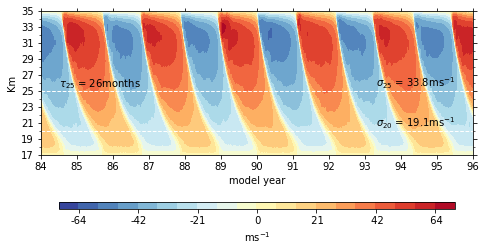

In [7]:
fig_size = (06.90, 02.20+01.50)
fig = plt.figure(figsize=fig_size)

ax = []

ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

cmin = -u.abs().max()
cmax = u.abs().max()

xmin = 84.
xmax = 96.
ymin = 17.
ymax = 35.

ax[0].set_xlim(left=84.)
ax[0].set_xlim(right=96.)
ax[0].set_ylim(bottom=17.)
ax[0].set_ylim(top=35.)

h = []
    
h.append(ax[0].contourf(solver.time/86400/360, solver.z/1000, u.T,
                        21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

ax[0].set_ylabel('Km', fontsize=10)

ax[0].set_xlabel('model year', fontsize=10)

xticks_list = np.arange(xmin, xmax+1, 1)
ax[0].set_xticks(xticks_list)

yticks_list = np.arange(ymin, ymax+2, 2)
ax[0].set_yticks(yticks_list)

xticklabels_list = list(xticks_list)
xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
ax[0].set_xticklabels(xticklabels_list, fontsize=10)

ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
ax[0].tick_params(which='both', labelbottom=True)

ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r'$\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r'$\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %tau25 + 'months',
              horizontalalignment='left', verticalalignment='bottom', color='black')

# # colorbars
cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
                      boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
                      label=r'$\mathrm{m s^{-1}}$')


## Prepare for the data

### Here we only use $u$ without concatnating $sf$ and $cw$

In [8]:
U = u[nspinup:nsteps, :]
s = model.s
s = s[nspinup:nsteps, :]

# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

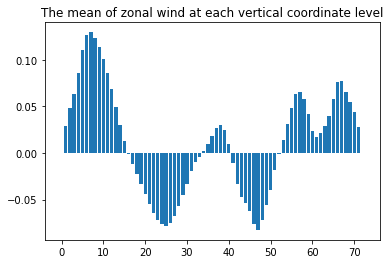

In [9]:
mean = U_train.mean(axis=0)
std = U_train.std(axis=0)
plt.bar(list(range(len(mean))), mean)
plt.title("The mean of zonal wind at each vertical coordinate level")
plt.show()
# This plot makes a lot of sense...
# Really makes sense...


# Linear Regression on $u$ (By sklearn)

In [47]:
reg = LinearRegression().fit(U_train, s_train)
prediction = reg.predict(U_test)
mean_l2_loss = np.linalg.norm((prediction - s_test.numpy()), axis=1).mean()
print(f"The loss of the linear regression: {mean_l2_loss}")
print(f"R-squared: {reg.score(U_test, s_test):.9f}")

The loss of the linear regression: 2.771425839605591e-05
R-squared: 0.895522434


## ONLINE testing

In [11]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE
model_ML = lambda x : torch.tensor(reg.coef_) @ x + torch.tensor(reg.intercept_)


u_ML = solver_ML.solve(source_func=model_ML)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [12]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

### Visualization(ML)

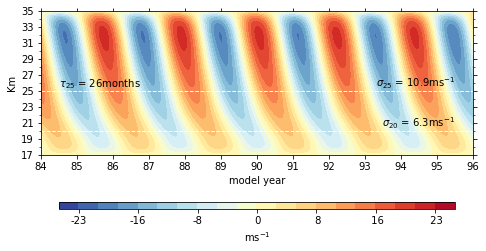

In [13]:
fig_size = (06.90, 02.20+01.50)
fig = plt.figure(figsize=fig_size)

ax = []

ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

cmin = -u_ML.abs().max()
cmax = u_ML.abs().max()

xmin = 84.
xmax = 96.
ymin = 17.
ymax = 35.

ax[0].set_xlim(left=84.)
ax[0].set_xlim(right=96.)
ax[0].set_ylim(bottom=17.)
ax[0].set_ylim(top=35.)

h = []
    
h.append(ax[0].contourf(solver_ML.time/86400/360, solver_ML.z/1000, u_ML.T,
                        21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

ax[0].set_ylabel('Km', fontsize=10)

ax[0].set_xlabel('model year', fontsize=10)

xticks_list = np.arange(xmin, xmax+1, 1)
ax[0].set_xticks(xticks_list)

yticks_list = np.arange(ymin, ymax+2, 2)
ax[0].set_yticks(yticks_list)

xticklabels_list = list(xticks_list)
xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
ax[0].set_xticklabels(xticklabels_list, fontsize=10)

ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
ax[0].tick_params(which='both', labelbottom=True)

ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25_ML + r'$\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20_ML + r'$\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %tau25_ML + 'months',
              horizontalalignment='left', verticalalignment='bottom', color='black')

# # colorbars
cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
                      boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
                      label=r'$\mathrm{m s^{-1}}$')


* The period is miraculously CORRECT... 
* The amplitude is not correct

# Linear Regression on $(u, sf, cw)$

## Prepare for the data

In [53]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)
cw, sf = model.cw, model.sf


tensor([0.0007, 0.1986])
tensor([[0.0007, 0.0090],
        [0.0090, 0.1986]])
tensor([-5.5998,  3.3664])


In [50]:
cw = cw[nspinup:nsteps]
sf = sf[nspinup:nsteps]
u = u[nspinup:nsteps, :]

s = model.s
s = s[nspinup:nsteps, :]

U = torch.hstack([u, sf.view(-1, 1), cw.view(-1, 1)])
print(f"The shape of data U is {U.shape}")


# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 34560 but got size 30240 for tensor number 1 in the list.

In [46]:
# Though it may be clear to do the linear regression manually
# But the runtime of sklearn is optimal
reg = LinearRegression().fit(U_train, s_train)
prediction = reg.predict(U_test)
mean_l2_loss = np.linalg.norm((prediction - s_test.numpy()), axis=1).mean()
print(f"The loss of the linear regression: {mean_l2_loss}")
print(f"R-squared: {reg.score(U_test, s_test):.9f}")



The loss of the linear regression: 2.771425839605591e-05
R-squared: 0.895522434


The loss and R-squared is similar to $U = u$

## ONLINE testing

In [49]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], sfe=3.7e-3, sfv=1e-8, cwe=32, cwv=225, corr=0.75, seed=int(21*9+8))

model_ML_aug = lambda x : torch.tensor(reg.coef_) @ torch.hstack([x, sf[solver_ML.current_step], cw[solver_ML.current_step]]) + torch.tensor(reg.intercept_)


u_ML = solver_ML.solve(source_func=model_ML_aug)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

tensor([0.0007, 0.1986])


RuntimeError: size mismatch, got 73, 73x73,75

In [18]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

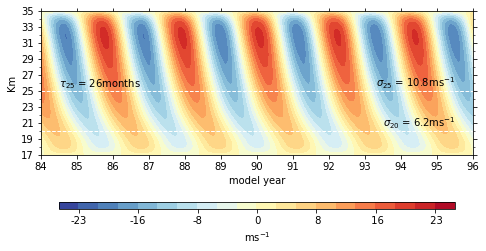

In [19]:
fig_size = (06.90, 02.20+01.50)
fig = plt.figure(figsize=fig_size)

ax = []

ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

cmin = -u_ML.abs().max()
cmax = u_ML.abs().max()

xmin = 84.
xmax = 96.
ymin = 17.
ymax = 35.

ax[0].set_xlim(left=84.)
ax[0].set_xlim(right=96.)
ax[0].set_ylim(bottom=17.)
ax[0].set_ylim(top=35.)

h = []
    
h.append(ax[0].contourf(solver_ML.time/86400/360, solver_ML.z/1000, u_ML.T,
                        21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

ax[0].set_ylabel('Km', fontsize=10)

ax[0].set_xlabel('model year', fontsize=10)

xticks_list = np.arange(xmin, xmax+1, 1)
ax[0].set_xticks(xticks_list)

yticks_list = np.arange(ymin, ymax+2, 2)
ax[0].set_yticks(yticks_list)

xticklabels_list = list(xticks_list)
xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
ax[0].set_xticklabels(xticklabels_list, fontsize=10)

ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
ax[0].tick_params(which='both', labelbottom=True)

ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25_ML + r'$\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20_ML + r'$\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %tau25_ML + 'months',
              horizontalalignment='left', verticalalignment='bottom', color='black')

#  colorbars
cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
                      boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
                      label=r'$\mathrm{m s^{-1}}$')

# Try normalization

I tried but it doesn't work well

In [20]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)


In [21]:
U = u[nspinup:nsteps, :]
s = model.s
s = s[nspinup:nsteps, :]

# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

In [22]:
mean_U_train = U_train.mean(axis=0)
std_U_train = U_train.std(axis=0) + 1e-32 # avoid dividing by 0
normalized_U_train = (U_train - mean_U_train)/std_U_train
normalized_U_test = (U_test - mean_U_train)/std_U_train

In [23]:
reg = Ridge(alpha=1).fit(normalized_U_train, s_train)
prediction = reg.predict(normalized_U_test)
mean_l2_loss = np.linalg.norm((prediction - s_test.numpy()), axis=1).mean()
print(f"THe loss of the linear regression: {mean_l2_loss}")
print(f"R-squared: {reg.score(normalized_U_test, s_test):.3f}")

THe loss of the linear regression: 2.7935106249965368e-05
R-squared: 0.894


## Online Testing

In [24]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)


def model_ML_norm(x):
    """
    Input: x, expected (73,) tensor
    Output: s, expected(73,) tensor
    """

    normed_x = (x - mean_U_train)/std_U_train
    
    return torch.tensor(reg.coef_) @ normed_x + torch.tensor(reg.intercept_)
    


u_ML = solver_ML.solve(source_func=model_ML_norm)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [25]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

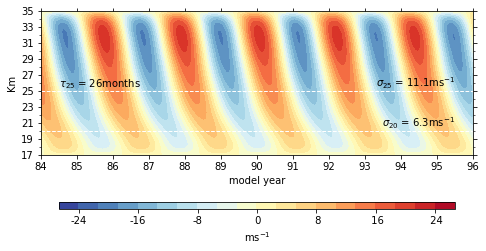

In [26]:
fig_size = (06.90, 02.20+01.50)
fig = plt.figure(figsize=fig_size)

ax = []

ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

cmin = -u_ML.abs().max()
cmax = u_ML.abs().max()

xmin = 84.
xmax = 96.
ymin = 17.
ymax = 35.

ax[0].set_xlim(left=84.)
ax[0].set_xlim(right=96.)
ax[0].set_ylim(bottom=17.)
ax[0].set_ylim(top=35.)

h = []
    
h.append(ax[0].contourf(solver_ML.time/86400/360, solver_ML.z/1000, u_ML.T,
                        21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

ax[0].set_ylabel('Km', fontsize=10)

ax[0].set_xlabel('model year', fontsize=10)

xticks_list = np.arange(xmin, xmax+1, 1)
ax[0].set_xticks(xticks_list)

yticks_list = np.arange(ymin, ymax+2, 2)
ax[0].set_yticks(yticks_list)

xticklabels_list = list(xticks_list)
xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
ax[0].set_xticklabels(xticklabels_list, fontsize=10)

ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
ax[0].tick_params(which='both', labelbottom=True)

ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25_ML + r'$\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20_ML + r'$\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %tau25_ML + 'months',
              horizontalalignment='left', verticalalignment='bottom', color='black')

#  colorbars
cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
                      boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
                      label=r'$\mathrm{m s^{-1}}$')

# Principle Components analysis

In [44]:
pca = PCA(n_components=5)
pca.fit(U)

PCA(n_components=5)

In [45]:
print(pca.explained_variance_ratio_)


[0.72211386 0.21139918 0.02723918 0.01867869 0.00658832]


* The first two components takes up almost all the weights.
* High collinaerity of features in U
* Regularization can be used